# Import Libraries and Load Dataset

This block imports all the necessary libraries for:

- Data manipulation: numpy, pandas
- Plotting: matplotlib, seaborn
- Modeling: DecisionTreeRegressor from sklearn.tree
- Evaluation: mean squared error, MAE, R², and scoring functions
- Cross-validation: KFold and Leave-One-Out (LOO)

After loading the dataset (FINAL_cleaned.csv), it selects the input features X and the target variable y. Unnecessary columns like country name, category label, and raw subregion names are excluded to focus the model on numeric predictors only.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

sns.set(style="whitegrid")
# Load the dataset
df = pd.read_csv('FINAL_cleaned.csv')
#print(df.head())

X = df.drop(columns=["Quality_of_Life_Value", "Quality_of_Life_Category","Country","Sub-region"])
y = df["Quality_of_Life_Value"]

print(X.head())
print(y.head())

   Sub_region_encoded  Coastline_wf   Latitude   Longitude  Elevation_m  \
0                  10         362.0  41.153332   20.168331        708.0   
1                   5         998.0  28.033886    1.659626        800.0   
2                   4        4989.0 -38.416097  -63.616672        595.0   
3                  12           0.0  40.069099   45.038189       1792.0   
4                   0       25760.0 -25.274398  133.775136        330.0   

   Temperature_C  
0          12.44  
1          23.60  
2          16.30  
3           7.82  
4          22.05  
0    104.16
1     98.83
2    115.06
3    116.56
4    190.69
Name: Quality_of_Life_Value, dtype: float64


### Train-Test Evaluation (80% / 20%)

This cell:

- Splits the dataset into 80% train and 20% test sets
- Trains a DecisionTreeRegressor on the training portion
- Makes predictions on the test set
- Reports the MSE, MAE, and R² scores

Decision Tree Regressor (Train/Test Split 80%):
  MSE: 1485.0784
  MAE: 32.4441
  R²: 0.4918


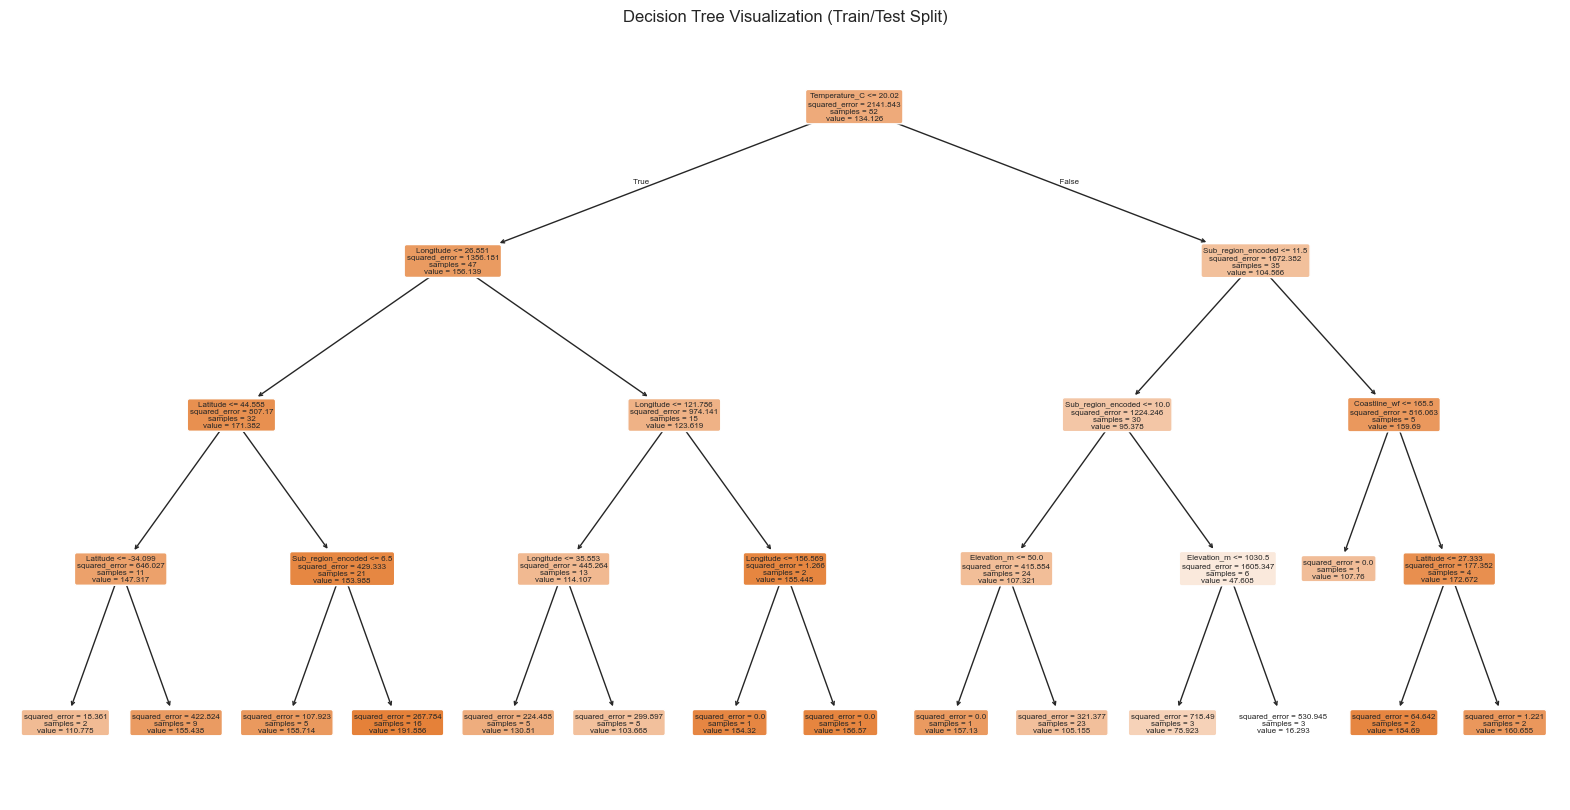

In [6]:
# Parameters
train_ratio = 0.8
random_state = 42

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_ratio, random_state=random_state
)

# Initialize and train the model
dt_model = DecisionTreeRegressor(max_depth=4, random_state=random_state)
dt_model.fit(X_train, y_train)

# Predict
y_pred = dt_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Decision Tree Regressor (Train/Test Split {train_ratio*100:.0f}%):")
print(f"  MSE: {mse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  R²: {r2:.4f}")

# Visualize the trained decision tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X.columns,
    filled=True,
    rounded=True
)
plt.title("Decision Tree Visualization (Train/Test Split)")
plt.show()


### 5-Fold Cross-Validation

**Different k values for K-Fold Cross-Validation was tested and it was decided that K=5 performs the best.**

This cell:

- Different k values for K-Fold Cross-Validation was tested and it was decided that K=5 performs the best
- Applies K-Fold Cross-Validation (k=5) with shuffle and fixed random seed
- Evaluates the model across folds using MSE, MAE, and R²
- Reports the mean and standard deviation for each metric across the 5 folds

In [3]:
# Define custom scorers
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize model
dt_model = DecisionTreeRegressor(random_state=42)

# Collect scores
mse_scores = -cross_val_score(dt_model, X, y, cv=kf, scoring=mse_scorer)
mae_scores = -cross_val_score(dt_model, X, y, cv=kf, scoring=mae_scorer)
r2_scores = cross_val_score(dt_model, X, y, cv=kf, scoring="r2")

# Display results
print("Decision Tree Regressor with 5-Fold CV:")
print(f"  MSE:  mean = {mse_scores.mean():.4f}, std = {mse_scores.std():.4f}")
print(f"  MAE:  mean = {mae_scores.mean():.4f}, std = {mae_scores.std():.4f}")
print(f"  R²:   mean = {r2_scores.mean():.4f}, std = {r2_scores.std():.4f}")

Decision Tree Regressor with 5-Fold CV:
  MSE:  mean = 1931.8547, std = 334.9161
  MAE:  mean = 33.0566, std = 2.9823
  R²:   mean = -0.0556, std = 0.5676


In [4]:
max_depth_values = [2, 3, 4, 5, 6]
min_samples_leaf_values = [1, 3, 5]

rows = []

for depth in max_depth_values:
    for leaf in min_samples_leaf_values:
        model = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=leaf, random_state=42)

        mse_scores = -cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
        mae_scores = -cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
        r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

        rows.append({
            "max_depth": depth,
            "min_samples_leaf": leaf,
            "MSE_mean": mse_scores.mean(),
            "MSE_std": mse_scores.std(),
            "MAE_mean": mae_scores.mean(),
            "MAE_std": mae_scores.std(),
            "R2_mean": r2_scores.mean(),
            "R2_std": r2_scores.std()
        })

df_dt_tuned = pd.DataFrame(rows)
display(df_dt_tuned.sort_values(by="R2_mean", ascending=False))


,max_depth,min_samples_leaf,MSE_mean,MSE_std,MAE_mean,MAE_std,R2_mean,R2_std
8,4,5,1667.111189,467.483925,31.861914,4.081765,0.082342,0.571212
14,6,5,1680.001984,469.502385,31.999520,3.842146,0.055040,0.597815
11,5,5,1703.309363,448.102006,32.268616,3.719519,0.046252,0.590863
9,5,1,1797.197114,425.539177,31.874763,4.309397,-0.001777,0.592162
3,3,1,1803.564301,616.821299,31.967919,6.061832,-0.010541,0.690849
7,4,3,1880.957804,552.221692,34.255275,5.484308,-0.014455,0.629492
13,6,3,1887.121329,646.137549,34.197622,6.833866,-0.016287,0.665087
5,3,5,1780.665438,600.397503,32.779061,4.558088,-0.017515,0.703387
10,5,3,1911.884159,552.860193,34.229417,6.303958,-0.025463,0.623974
6,4,1,1871.182148,506.957449,34.310584,4.972049,-0.034241,0.648002


### Leave-One-Out Cross-Validation (LOO-CV)

This cell:

- Applies Leave-One-Out Cross-Validation, where each data point is used once as the test set
- Trains and tests the model n times (where n = number of samples)
- Provides a more granular and low-bias estimate of model performance but at higher computational cost
- Reports the mean and standard deviation for MSE, MAE, and R² (R² cannot be computed as before)

In [13]:
loo = LeaveOneOut()

rows_dt_loo = []

for depth in max_depth_values:
    for leaf in min_samples_leaf_values:
        model = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=leaf, random_state=42)

        mse_scores = -cross_val_score(model, X, y, cv=loo, scoring=mse_scorer)
        mae_scores = -cross_val_score(model, X, y, cv=loo, scoring=mae_scorer)

        rows_dt_loo.append({
            "split": "LOO",
            "max_depth": depth,
            "min_samples_leaf": leaf,
            "MSE_mean": mse_scores.mean(),
            "MSE_std": mse_scores.std(),
            "MAE_mean": mae_scores.mean(),
            "MAE_std": mae_scores.std(),
            "R2_mean": None,
            "R2_std": None
        })

df_dt_loo = pd.DataFrame(rows_dt_loo)
display(df_dt_loo.sort_values(by="MSE_mean"))  # lower MSE is better


,split,max_depth,min_samples_leaf,MSE_mean,MSE_std,MAE_mean,MAE_std,R2_mean,R2_std
9,LOO,5,1,1340.596590,2862.800417,27.170786,24.542718,None,None
14,LOO,6,5,1420.496779,2548.931156,28.845248,24.257957,None,None
11,LOO,5,5,1456.214282,2564.524917,29.401377,24.326391,None,None
13,LOO,6,3,1506.578045,2689.971235,29.962903,24.673923,None,None
7,LOO,4,3,1508.962896,2588.282637,30.141090,24.504645,None,None
8,LOO,4,5,1517.098773,2563.008366,30.151019,24.657957,None,None
10,LOO,5,3,1523.174939,2687.473648,30.128185,24.808616,None,None
4,LOO,3,3,1567.633141,2582.580814,31.183041,24.397768,None,None
5,LOO,3,5,1569.791261,2612.035291,31.033130,24.632013,None,None
12,LOO,6,1,1634.349560,3753.446722,29.291039,27.863679,None,None


<img src="DT.png" width="500"/>


LOO-CV (best): 1340.60 — lowest overall error

Train/Test Split: 1620.85 — moderate, but less stable

5-Fold CV (best): 1667.11 — slightly higher but with full metrics available